In [1]:
from numpy.random import choice, normal, uniform, binomial
from numpy import sum, mean, zeros, array, NaN, sqrt
import pandas as pd
from math import comb
from numpy.random import seed
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

In [2]:
pd.options.mode.chained_assignment = None
seed(1234)

# Bias under different samplig sizes

We are going to replicate the `Synthetic Simulation.ipynb` many times to see whether bias disappears increasing the sample size or the number of simultaneous recommendations. 

Values to combine and try

In [3]:
items_n_values = [10, 20, 30]
k_prop_values = [0.1, 0.25, 0.5, 0.75, 0.9] 

Default parameters configuration

In [4]:
patients_n = 10000
sessions_n = 2
delta = 0.1
exploration_prob = 0.8

prob_enthusiast = 0.2
enthusiast_effect = 10
base_consumption = 0.2
inc_enth_cons = 0.8

In [5]:
def simulate(items_n, k):
    ids = []
    sessions = []
    patient_types = []
    items = []
    recommendations = []
    consumptions = []
    originals = []
    explorations = []

    items_ids = list(range(items_n))
    for id in range(patients_n):
        patient_type = choice([0, 1], size=1, p=[1-prob_enthusiast, prob_enthusiast])[0]
        for session in range(sessions_n):
            exploration = binomial(1, exploration_prob, size=1)[0]
            original = None
            if patient_type == 1:
                original = items_ids[:k]
            else:
                original = items_ids[-k:]
            if exploration == 1:
                recommended = choice(items_ids, size=k, replace=False)
            else:
                recommended = original

            recommended = [int(item in recommended) for item in items_ids]     
            original = [int(item in original) for item in items_ids]     

            consumption = []
            for item in range(items_n):
                score_assign = base_consumption + inc_enth_cons*patient_type
                item_cons = int(uniform(size=1)[0] <= score_assign)
                item_cons *= recommended[item]
                consumption.append(item_cons)

            ids += [id]*items_n
            sessions += [session]*items_n
            patient_types += [patient_type]*items_n
            items += items_ids
            recommendations += recommended
            consumptions += consumption
            explorations += [exploration]*items_n
            originals += original

    df = pd.DataFrame({
        'user_id': ids,
        'session': sessions, 
        'patient_type': patient_types,
        'item': items, 
        'original': originals,
        'recommended': recommendations,
        'consumed': consumptions,
        'exploration': explorations
    })

    outcomes = df.groupby('user_id').apply(lambda x: 
        (sum(x['item']*x['consumed'])/(items_n*sessions_n) + 
        mean(x['patient_type'])*enthusiast_effect + 
        normal(size=1, scale=delta))[0]
    ).reset_index()
    outcomes.rename(columns={0:'outcome'}, inplace = True)
    df = df.merge(outcomes, on='user_id')
    recs = df.pivot(index=['user_id', 'session', 'exploration'], columns='item', values='recommended').reset_index().merge(outcomes, on='user_id')
    originals = df.pivot(index=['user_id', 'session', 'exploration'], columns='item', values='original').reset_index().merge(outcomes, on='user_id')
    return(df, recs, original)



In [6]:
def calculate_expected(df, recs, items_n):
    expected_diff_items = zeros((items_n, items_n))
    expected_compliers = base_consumption*(1-prob_enthusiast) + (base_consumption + inc_enth_cons)*prob_enthusiast
    for item_1 in range(items_n):
        for item_2 in range(items_n):
            expected_diff_items[item_1, item_2] = (item_1 - item_2)*expected_compliers/(items_n*sessions_n)

    expected_diff_items = pd.DataFrame(expected_diff_items)
    return(expected_diff_items)

In [7]:
def calculate_direct(df, recs, items_n):
    diff_items_direct = zeros((items_n, items_n))

    for item_1 in range(items_n):
        for item_2 in range(items_n):
            try: 
                inds_1_0 = recs.loc[:, item_1] == 1
                inds_2_0 = recs.loc[:, item_2] == 1
                res_1 = recs[inds_1_0].loc[:, 'outcome'].mean() - recs[inds_2_0].loc[:, 'outcome'].mean()
            except:
                res_1 = NaN
            diff_items_direct[item_1, item_2] = res_1

    diff_items_direct = pd.DataFrame(diff_items_direct)
    return(diff_items_direct)

In [8]:
def estimate_differences(df, k, exploration_prob):

    outcomes = df.groupby(['user_id', 'session'], as_index=False).outcome.mean()
    recs = df.pivot_table(
        index=['user_id', 'session', 'exploration'], 
        columns='item', values='recommended', fill_value=0). \
        reset_index().merge(outcomes, on='user_id')
    originals = df.pivot_table(
        index=['user_id', 'session', 'exploration'], 
        columns='item', values='original', fill_value=0). \
        reset_index().merge(outcomes, on='user_id')

    items_ids = df.item.unique()
    N = len(items_ids)
    diff_items = zeros((N, N))
    q = exploration_prob/comb(N-2, k-1)

    for item_1 in range(items_n - 1):
        for item_2 in range(item_1 + 1, items_n):
            other_itemments = [t for t in items_ids if t not in [item_1, item_2]]

            # Calculate Propensity Scores
            L = recs[other_itemments]*originals[other_itemments]
            L += (1 -recs[other_itemments])*(1-originals[other_itemments])
            L = (L.apply(sum, axis=1) == N-2).astype(int)
            eta = q/(q + L*(1-exploration_prob))
            propensity_scores = eta/2 + L*originals[item_1]*(1-eta)

            # Calculating Adjustment Formula
            inds = recs[item_1] != recs[item_2]
            diff_data = recs[inds]
            diff_data['propensity_scores'] = propensity_scores[inds]
            diff_ate = 0
            for control_vars, sub_data in diff_data.groupby('propensity_scores'):
                prop = sub_data.shape[0]/diff_data.shape[0]
                res = sub_data.groupby(item_1).outcome.mean()
                if res.shape[0] > 1:
                    diff_ate += (res.iloc[1] - res.iloc[0])*prop
            diff_items[item_1, item_2] = diff_ate
            diff_items[item_2, item_1] = -diff_ate

    return(pd.DataFrame(diff_items))

In [9]:
def rank_differences(results):
    rank = results.iloc[:, 0]
    for col in range(1, results.shape[0]):
        rank += results.iloc[:, col] - results.iloc[col, 0]
    rank /= results.shape[0]
    return(rank.sort_values(ascending=False))

In [10]:
def rmse(rank_1, rank_2):
    rank_1 = pd.DataFrame(rank_1).reset_index()
    rank_2 = pd.DataFrame(rank_2).reset_index()
    rank_diff = rank_1.merge(rank_2, on='index')
    return(sqrt(((rank_diff.iloc[:, 1] - rank_diff.iloc[:, 2])**2).mean()))

# Simulate

In [11]:
list_ = [items_n_values, k_prop_values]
combinations = [p for p in product(*list_)]

In [12]:
items_n_list = []
k_prop_list = []
rmse_method = []
rmse_direct = []

for items_n, k_prop in tqdm(combinations):
    k = int(items_n*k_prop)
    df, recs, originals = simulate(items_n, k)

    diff_items_method = estimate_differences(df, k, exploration_prob)
    rank_method = rank_differences(diff_items_method)

    diff_items_direct = calculate_direct(df, recs, items_n)
    rank_direct = rank_differences(diff_items_direct)

    diff_items_expected = calculate_expected(df, recs, items_n)
    rank_expected = rank_differences(diff_items_expected)

    rmse_method.append(rmse(rank_method, rank_expected))
    rmse_direct.append(rmse(rank_direct, rank_expected))
    items_n_list.append(items_n)
    k_prop_list.append(k_prop)

results = pd.DataFrame({
    'items_n': items_n_list,
    'k_prop': k_prop_list,
    'ours': rmse_method,
    'direct': rmse_direct
})

100%|████████████████████████████████████████| 15/15 [3:21:23<00:00, 805.58s/it]


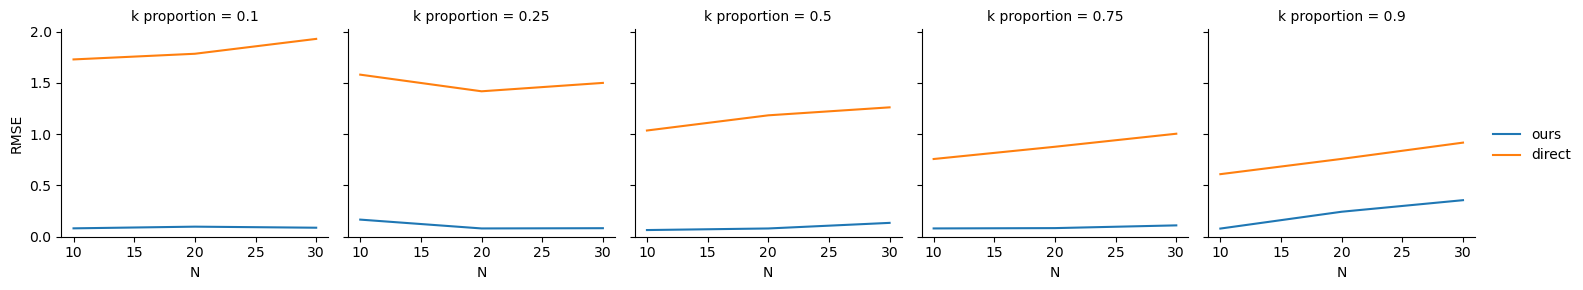

In [13]:
results_ = results.melt(id_vars = ['items_n', 'k_prop'], value_vars = ['ours', 'direct'])
results_ = results_.rename(columns={'value': 'RMSE', 'items_n': 'N', 'variable': 'method', 'k_prop': "k proportion"})
g = sns.FacetGrid(results_, col="k proportion")
g.map(sns.lineplot, "N", "RMSE", 'method').add_legend()
plt.ylim(0)
plt.savefig('items_n_comparison.png')